In [1]:
#Zone Anomaly

In [2]:
def zoneAnomaly (tIn,qFlo,qFloSp,sRad):

    #Remove stagnant and nan values
    mask = tIn.rolling(24).std().mean(axis=1) < 0.001
    for df in [tIn,qFlo,qFloSp,sRad]:
        df.drop(df[mask].index, inplace=True)      
    
    #Extract workhours in WINTER (December-February)
    mask = ((tIn.index.hour>9)&(tIn.index.hour<17)) & (tIn.index.weekday<5) & ((tIn.index.month>11)|(tIn.index.month<3))
    tInWntr = tIn[mask].mean(axis=0)
    qFloWntr = qFlo[mask]
    qFloSpWntr = qFloSp[mask]
    qFloWntrErr = ((qFloWntr-qFloSpWntr)/qFloSpWntr).mean(axis=0)
    sRadWntr = sRad[mask].mean(axis=0)

    tInErrNrm = tInWntr / np.linalg.norm(tInWntr)
    qFloErrNrm = qFloWntrErr / np.linalg.norm(qFloWntrErr)
    
    if sRadWntr.max() > 1:
        sRadNrm = sRadWntr/100
    else:
        sRadNrm = sRadWntr

    frameWntr = pd.concat([tInErrNrm,qFloErrNrm,sRadNrm],axis=1, join='inner')
    
    best_score = 0
    for n in range(3,5): # loop through 3 to 4 clusters
        evaKMeans = cluster.KMeans(n_clusters=n,random_state=1).fit_predict(frameWntr) #Create cluster labels
        kmeans_score = metrics.calinski_harabasz_score(frameWntr, evaKMeans) # Score cluster labels

        evaGMdist = mixture.GaussianMixture(n_components=n,covariance_type='full').fit_predict(frameWntr)
        gmm_score = metrics.calinski_harabasz_score(frameWntr, evaGMdist)
        
        evaLinkage = cluster.AgglomerativeClustering(n_clusters=n).fit_predict(frameWntr)
        link_score = metrics.calinski_harabasz_score(frameWntr, evaLinkage)

        #Find best clustering method and take k-clusters
        if kmeans_score > best_score:
            best_score = kmeans_score
            eva = evaKMeans
            optimalK = n
        if gmm_score > best_score:
            best_score = gmm_score
            eva = evaGMdist
            optimalK = n
        if link_score > best_score:
            best_score = link_score
            eva = evaLinkage
            optimalK = n

    #Draw cluster plot
    fig, ax = plt.subplots(figsize=(12,10))
    ax.set_ylabel(r'$\frac{q_{flo} - q_{flo,sp}}{q_{flo,sp}}$ (%)', fontsize=38)
    ax.set_xlabel(r'$t_{in}(C)$', fontsize=38)
    ax.text(22.5, 10, 'OK', fontsize=25, ha='center')
    ax.text(16, 2, 'Cold', fontsize=25)
    ax.text(28, 2, 'Hot', fontsize=25)
    ax.text(21.5, 80, 'High flow', fontsize=25)
    ax.text(21.5,-80, 'Low flow', fontsize=25)
    ax.set_xlim(15,30)
    ax.set_ylim(-100,100)
    plt.xticks(np.arange(15, 31, 3))
    plt.yticks(np.arange(-100, 101, 20))
    ax.set_xticklabels(np.arange(15, 31, 3), fontsize=23)
    ax.set_yticklabels(np.arange(-100, 101, 20), fontsize=23)
    plt.tight_layout()
    
    #Pretty bad - red box
    rect = plt.Rectangle((15,-100), 15, 200, fc='r', alpha=0.1)
    ax.add_patch(rect)

    #Not so bad - yellow box
    rect = plt.Rectangle((18,-50), 9, 100, fc='yellow', ec='k', alpha = 0.1, lw=2)
    ax.add_patch(rect)

    #OK - green box
    rect = plt.Rectangle((20,-20), 5, 40, fc='lime', ec='k', alpha = 0.1, lw=2)
    ax.add_patch(rect)

    centerClust = pd.DataFrame(columns = ['Zones','Mean t_in','Mean q_Flo Error','Mean s_Rad'])
    for i in range(0,optimalK): #Extract zones identified in clustering solution per cluster and plot 
        
        x = tInWntr.to_frame().T.loc[:, eva==i].stack().mean() #Temp Bias
        y = (qFloWntrErr.to_frame().T.loc[:, eva==i]*100).stack().mean() #Flow Bias
        z = sRadWntr.to_frame().T.loc[:, eva==i].stack().mean() #Mean rad state
        centerClust = centerClust.append({'Zones':sum(eva==i),'Mean t_in':x,'Mean q_Flo Error':y,'Mean s_Rad':z},ignore_index=True) #cluster center
        if ((x>15) & (x<30) & (y>-100) &(y<100)):
            t = plt.text(x, y, 'C'+str(i+1), fontsize=25, color = 'w', ha = 'center', va= 'center')
            t.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='black'))
        t = plt.text(15.2, 99.5 - 7*(i+1), 'C'+str(i+1)+', n='+str(sum(eva==i))+ r', $s_{rad}$='+str(round(z))+'%', fontsize=20, alpha=0.5)

    #Compute Winter Health index - count number of zones where the cluster falls beyond threshold.
    centerClust['Health Index'] = ''
    centerClust['Health Index'][0] = 1 - centerClust.loc[(centerClust['Mean t_in']>25) | (centerClust['Mean t_in']<20) | (centerClust['Mean q_Flo Error']>20) | (centerClust['Mean q_Flo Error']<-20), 'Zones'].sum()/centerClust['Zones'].sum()
    t = plt.text(24,-98,'Health Index=' + str(round(centerClust['Health Index'].iloc[0]*100,1))+'%', fontsize=25, alpha=0.5)

    plt.savefig(output_path + r'\zone_heat_season.png')
    zoneWinterSummary = centerClust


    #Extract workhours in SUMMER (May-August)
    mask = ((tIn.index.hour>9)&(tIn.index.hour<17)) & (tIn.index.weekday<5) & ((tIn.index.month>4)|(tIn.index.month<9))
    tInSmr = tIn[mask].mean(axis=0)
    qFloSmr = qFlo[mask]
    qFloSpSmr = qFloSp[mask]
    qFloSmrErr = ((qFloSmr-qFloSpSmr)/qFloSpSmr).mean(axis=0)

    tInErrNrm = tInSmr / np.linalg.norm(tInSmr)
    qFloErrNrm = qFloSmrErr / np.linalg.norm(qFloSmrErr)

    frameSmr = pd.concat([tInErrNrm,qFloErrNrm],axis=1)
    
    best_score = 0
    for n in range(3,6): # loop through 3 to 5 clusters
        evaKMeans = cluster.KMeans(n_clusters=n,random_state=1).fit_predict(frameSmr) #Create cluster labels
        kmeans_score = metrics.calinski_harabasz_score(frameSmr, evaKMeans) # Score cluster labels

        evaGMdist = mixture.GaussianMixture(n_components=n,covariance_type='full').fit_predict(frameSmr)
        gmm_score = metrics.calinski_harabasz_score(frameSmr, evaGMdist)
        
        evaLinkage = cluster.AgglomerativeClustering(n_clusters=n).fit_predict(frameSmr)
        link_score = metrics.calinski_harabasz_score(frameSmr, evaLinkage)


        #Find best clustering method and take k-clusters
        if kmeans_score > best_score:
            best_score = kmeans_score
            eva = evaKMeans
            optimalK = n
        if gmm_score > best_score:
            best_score = gmm_score
            eva = evaGMdist
            optimalK = n
        if link_score > best_score:
            best_score = link_score
            eva = evaLinkage
            optimalK = n

    #Draw cluster plot
    fig, ax = plt.subplots(figsize=(12,10))
    ax.set_ylabel(r'$\frac{q_{flo} - q_{flo,sp}}{q_{flo,sp}}$ (%)', fontsize=38)
    ax.set_xlabel(r'$t_{in}(C)$', fontsize=38)
    ax.text(22.5, 10, 'OK', fontsize=25, ha='center')
    ax.text(16, 2, 'Cold', fontsize=25)
    ax.text(28, 2, 'Hot', fontsize=25)
    ax.text(21.5, 80, 'High flow', fontsize=25)
    ax.text(21.5,-80, 'Low flow', fontsize=25)
    ax.set_xlim(15,30)
    ax.set_ylim(-100,100)
    plt.xticks(np.arange(15, 31, 3))
    plt.yticks(np.arange(-100, 101, 20))
    ax.set_xticklabels(np.arange(15, 31, 3), fontsize=23)
    ax.set_yticklabels(np.arange(-100, 100, 20), fontsize=23)
    plt.tight_layout()

    #Pretty bad - red box
    rect = plt.Rectangle((15,-100), 15, 200, fc='r', alpha=0.1)
    ax.add_patch(rect)

    #Not so bad - yellow box
    rect = plt.Rectangle((18,-50), 9, 100, fc='yellow', ec='k', alpha = 0.1, lw=2)
    ax.add_patch(rect)

    #OK - green box
    rect = plt.Rectangle((20,-20), 5, 40, fc='lime', ec='k', alpha = 0.1, lw=2)
    ax.add_patch(rect)

    centerClust = pd.DataFrame(columns = ['Zones','Mean t_in','Mean q_Flo Error'])
    for i in range(0,optimalK): #Extract zones identified in clustering solution per cluster and plot 
        
        x = tInSmr.to_frame().T.loc[:, eva==i].stack().mean() #Temp Bias
        y = (qFloSmrErr.to_frame().T.loc[:, eva==i]*100).stack().mean() #Flow Bias
        centerClust = centerClust.append({'Zones':sum(eva==i),'Mean t_in':x,'Mean q_Flo Error':y},ignore_index=True) #cluster center
        if ((x>15) & (x<30) & (y>-100) &(y<100)):
            t = plt.text(x, y, 'C'+str(i+1), fontsize=25, color = 'w', ha = 'center', va= 'center')
            t.set_bbox(dict(facecolor='black', alpha=0.75, edgecolor='black'))
        t = plt.text(15.2, 99.5 - 7*(i+1), 'C'+str(i+1)+', n='+str(sum(eva==i)), fontsize=20, alpha=0.5)

    #Compute Summer Health index - count number of zones where the cluster falls beyond threshold.
    centerClust['Health Index'] = ''
    centerClust['Health Index'][0] = 1 - centerClust.loc[(centerClust['Mean t_in']>25) | (centerClust['Mean t_in']<20) | (centerClust['Mean q_Flo Error']>20) | (centerClust['Mean q_Flo Error']<-20), 'Zones'].sum()/centerClust['Zones'].sum()
    t = plt.text(24,-98,'Health Index=' + str(round(centerClust['Health Index'].iloc[0]*100,1))+'%', fontsize=25, alpha=0.5)

    plt.savefig(output_path + r'\zone_cool_season.png')
    zoneSummerSummary = centerClust

    return zoneWinterSummary,zoneSummerSummary
    

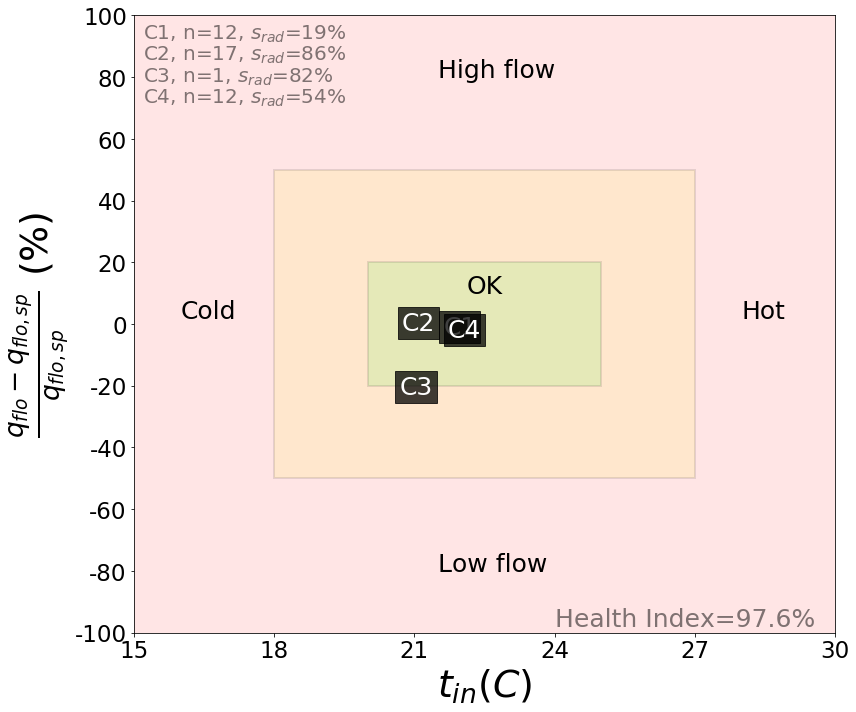

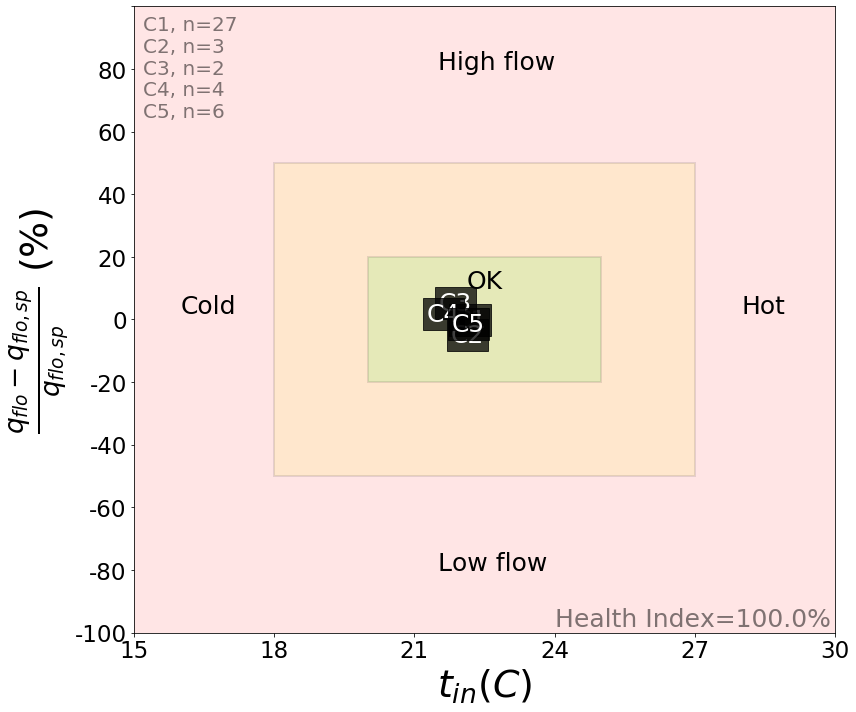

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn import cluster,preprocessing,metrics,mixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Specify current directory and input/output paths
path = os.getcwd() #Get current directory
zone_input_path = path + r'\sample data\zone'
output_path = path + r'\output'

zone_files = os.listdir(path + r'\sample data\zone')
zone_files_csv = [f for f in zone_files if f[-3:] == 'csv']

#Create empty dataframes
tIn = pd.DataFrame()
qFlo = pd.DataFrame()
qFloSp = pd.DataFrame()
sRad = pd.DataFrame()

#Populate tIn,qFlo,qFloSp,and sRad dataframes
for f in zone_files_csv:
    data = pd.read_csv(zone_input_path + '\\' + f, index_col=0)
    tIn = pd.concat([tIn,data[data.columns[0]]], axis=1,sort=False).rename(columns={data.columns[0]:str(f).replace('.csv','')})
    qFlo = pd.concat([qFlo,data[data.columns[1]]], axis=1,sort=False).rename(columns={data.columns[1]:str(f).replace('.csv','')})
    qFloSp = pd.concat([qFloSp,data[data.columns[2]]], axis=1,sort=False).rename(columns={data.columns[2]:str(f).replace('.csv','')})
    sRad = pd.concat([sRad,data[data.columns[3]]], axis=1,sort=False).rename(columns={data.columns[3]:str(f).replace('.csv','')})

#Set index of all dataframes to datetime
for df in [tIn,qFlo,qFloSp,sRad]:
    df.index = pd.to_datetime(df.index)

WntrZoneSummary,SmrZoneSummary = zoneAnomaly(tIn,qFlo,qFloSp,sRad)

writer = pd.ExcelWriter(output_path + r'\zone_anomaly_summary.xlsx', engine='xlsxwriter')
WntrZoneSummary.to_excel(writer, sheet_name='Heating season')
SmrZoneSummary.to_excel(writer, sheet_name='Cooling season')
writer.save()
